<a href="https://colab.research.google.com/github/glassresearch/PLT/blob/master/Python%20colab%20Georgia%20Tech/triangle-counting-three-ways.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!wget https://github.com/gt-cse-6040/skills_oh_week_08/raw/main/im.db

--2025-10-21 17:30:48--  https://github.com/gt-cse-6040/skills_oh_week_08/raw/main/im.db
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gt-cse-6040/skills_oh_week_08/main/im.db [following]
--2025-10-21 17:30:48--  https://raw.githubusercontent.com/gt-cse-6040/skills_oh_week_08/main/im.db
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17055744 (16M) [application/octet-stream]
Saving to: ‘im.db’

im.db               100%[===================>]  16.27M  --.-KB/s    in 0.1s    

2025-10-21 17:30:49 (156 MB/s) - ‘im.db’ saved [17055744/17055744]



In [5]:
# Startup code
from sqlite3 import connect
from pandas import read_sql_query
from IPython.display import Markdown

t_start__ = 0
def start_timer():
    from time import time
    global t_start__
    t_start__ = time()
    return 0

def elapsed(t_elapsed=0):
    from time import time
    assert t_start__ > 0, "Did you start the timer yet?"
    t_elapsed += time() - t_start__
    return t_elapsed

def stop_timer(t_elapsed=0):
    t_elapsed = elapsed(t_elapsed)
    t_start__ = 0
    return t_elapsed

# Triangle counting, three-ways #

There are some deeper differences and connections between the "[three ways](https://www.npr.org/sections/thesalt/2013/08/12/211408192/three-ways-cooking-has-changed-over-the-last-300-years)" you've worked with [_relational data:_](https://www.seas.upenn.edu/~zives/03f/cis550/codd.pdf) SQL, pandas, and (for sparse network/graph data) Numpy/Scipy (sparse) matrices.

Recall that a _relational database_ organizes data into tables, where rows are like "data points" or "data items" and columns are "attributes" or "features." A table is also called a _relation._

For example, here is a table of customers:

 | cust_id | name  | dob        | income    |
 |:-------:|:-----:|:----------:|:---------:|
 | 123     | alice | 06/01/1974 |  \$84,000 |
 | 852     | bob   | 03/18/2001 |  \$35,500 |
 | 1048    | carol | 11/24/1990 | \$127,000 |

Two tables or relations may be "linked" by common columns. You might maintain a table of purchases where rows hold items purchased and one of the columns is a customer ID, which matches the ID from the table of customers.  

_Query languages_ help manipulate, transform, and summarize information from one or more tables. For instance, here is how you might find the average income of all customers who purchased a certain kind of item in SQL and pandas:

```sql
-- SQL:
SELECT AVG(Customers.income) AS avg_inc
    FROM Customers, Purchases
    WHERE Purchases.sku = '12QJ581LX'
          AND Customers.cust_id = Purchases.cust_id
    GROUP BY Customers.cust_id
```

```python
# pandas:
item_purchases = purchases[purchase['sku'] == '12QJ581LX']
results = customers.merge(purchases_for_item, on='cust_id')\
                   .groupby('cust_id')['income'].mean()
```

## Declarative vs. imperative languages ##

Although they have similar functionality, SQL and pandas can be _very_ different!

* SQL is _declarative:_ your code says what the output should look like but lets SQL decide _how_ to produce that result;
* pandas is _imperative:_ you decide what steps to take to produce a desired result.

Let's see how with a concrete example: counting triangles in a social network.

## Example: Triangle counting ##

Suppose we are analyzing the structure of communities in a social network. Such structures can help make recommendations or fight the flow of misinformation, for instance. An example of a structure is a _triangle,_ which is a set of three people or entities that are mutually linked. The following graph has two triangles: (0, 1, 3) and (0, 3, 5).

![Triangle sample](https://github.com/gt-cse-6040/skills_oh_week_08/blob/main/graph.png?raw=1)

## Triangles in the Internet Movie Database (IMDB) ##

As an example, suppose we want to count the total number of triangles in the network of Hollywood actors, where two actors are linked if they co-starred in a movie together.

Here is some data from IMDB, the [Internet Movie Database](https://imdb.com). It's stored in a SQLite database with three tables, one for _movies,_ one for _actors,_ and one for _casts_ (a cast is the list of actors who starred in a movie).

In [6]:
# Database of casts in the Top 250 movies (circa 2015?)
imdb = connect('im.db')
imdb_cur = imdb.cursor()

In [5]:
read_sql_query('SELECT * FROM Movies LIMIT 3', imdb)

,movie_id,link,title
0,1,tt0111161,The Shawshank Redemption
1,2,tt0068646,The Godfather
2,3,tt0071562,The Godfather: Part II


In [6]:
read_sql_query('SELECT * FROM Actors LIMIT 3', imdb)

,actor_id,link,name
0,1,nm1067524,Sarah Hudson
1,2,nm0058044,John Barry
2,3,nm0350454,Maggie Gyllenhaal


In [7]:
read_sql_query('SELECT * FROM Casts LIMIT 3', imdb)

,movie_id,actor_id
0,5,12103
1,5,855
2,5,6619


## Method 0: Counting triangles using SQL ##

Since the data reside natively in a SQL database, let's use SQL queries to count the triangles.

First, observe that a triangle exists if actors $a$ and $b$ are co-stars, $b$ and $c$ are co-stars, and $a$ and $c$ are co-stars.

So let's start by **tabulating pairs** of actors who co-starred in any movie together. We can do that by joining the `Casts` table with itself, matching pairs of _distinct_ actors who appeared in the same movie.

In [8]:
# Recall: `Casts` table
read_sql_query('SELECT * FROM Casts LIMIT 3', imdb)

,movie_id,actor_id
0,5,12103
1,5,855
2,5,6619


In [9]:
t_make_costars = start_timer()

In [21]:
display(read_sql_query(r'''
SELECT A.actor_id AS A, B.actor_id AS B
  FROM Casts A, Casts B
  WHERE A.movie_id = B.movie_id AND
        A.actor_id != B.actor_id
  GROUP BY A.actor_id, B.actor_id''',imdb))


,A,B
0,0,2
1,0,381
2,0,716
3,0,1987
4,0,2223
...,...,...
1246807,12974,12578
1246808,12974,12592
1246809,12974,12815
1246810,12974,12872


In [8]:
query_make_pairs = r'''
CREATE VIEW Costars AS
    SELECT X.actor_id AS a, Y.actor_id AS b
      FROM Casts AS X, Casts AS Y
     WHERE (X.movie_id = Y.movie_id) AND (X.actor_id <> Y.actor_id)
  GROUP BY X.actor_id, Y.actor_id'''

(This code constructs pairs $(a, b)$ such that $a \neq b$.)

In [8]:
imdb_cur.execute('DROP VIEW IF EXISTS Costars')
imdb_cur.execute(query_make_pairs)

In [12]:
t_make_costars = stop_timer(t_make_costars)

In [13]:
display(read_sql_query('SELECT * FROM Costars', imdb))

,a,b
0,0,2
1,0,381
2,0,716
3,0,1987
4,0,2223
...,...,...
1246807,12974,12578
1246808,12974,12592
1246809,12974,12815
1246810,12974,12872


And by the way, it's not a small number of co-star pairs...

In [14]:
display(read_sql_query('SELECT COUNT(*) AS num_movies FROM Movies', imdb))
display(read_sql_query('SELECT PRINTF("%,d", COUNT(*)) AS num_actors FROM Actors', imdb))
display(read_sql_query('SELECT PRINTF("%,d", COUNT(*)) AS num_costar_pairs FROM Costars', imdb))
print(f"==> Time to construct `Costars` table: {t_make_costars:.3f} sec")

,num_movies
0,250


,num_actors
0,"12,975"


,num_costar_pairs
0,"1,246,812"


==> Time to construct `Costars` table: 11.878 sec


**Counting triangles.** A triangle $(a, b, c)$ exists if $(a, b)$, $(b, c)$, and $(c, a)$ are all valid co-star pairs.

Suppose we write down every such triple, $(a, b, c)$. The number of triangles is the number of such triples _divided by 6_ because there are $3! = 6$ different combinations of $(a, b, c)$, like $(c, b, a)$ or $(a, c, b)$, that can appear.

In [15]:
t_sql = start_timer()

In [16]:
query_triangles = r'''SELECT COUNT(*) / 6 AS num_triangles
                        FROM Costars AS X, Costars AS Y, Costars AS Z
                       WHERE (X.b = Y.a) AND (Y.b = Z.a) AND (X.a = Z.b)'''

In [18]:
sql_tricount_df = read_sql_query(query_triangles, imdb)

In [17]:
t_sql = stop_timer(t_sql)

In [27]:
display(sql_tricount_df)
print(f"==> SQL method found {sql_tricount_df['num_triangles'].loc[0]:,} triangles in {t_sql:.3f} sec")

,num_triangles
0,24620528


==> SQL method found 24,620,528 triangles in 2479.759 sec


This query is **declarative.**

```sql
SELECT COUNT(*) / 6 AS num_triangles
  FROM Costars AS X, Costars AS Y, Costars AS Z
 WHERE (X.b = Y.a) AND (Y.b = Z.a) AND (X.a = Z.b)
```

We don't tell the computer what steps to perform or in what order. Instead, we specify the form of the result (the `SELECT` columns) and express the _properties_ that the result should have (the `WHERE` subclause). We assume the computer can figure out exactly how to loop over the data efficient to compute the final results.

## Method 1: Pandas ##

We can do the same calculation in pandas, of course. But the big difference is that we need to tell the computer _how_ to do the query, meaning what state to create or change and exactly what steps to take.

This style of programming is referred to as being _imperative._

Let's start with the co-stars table, extracted as a pandas dataframe.

In [10]:
costars_df = read_sql_query('SELECT * FROM Costars', imdb)
costars_df.head()

,a,b
0,0,2
1,0,381
2,0,716
3,0,1987
4,0,2223


The SQL query joined this table with itself:

```sql
SELECT COUNT(*) / 6 AS num_triangles
  FROM Costars AS X, Costars AS Y, Costars AS Z
 WHERE (X.b = Y.a) AND (Y.b = Z.a) AND (X.a = Z.b)
```

In [7]:
t_pd = start_timer()

What's a pandas analogue? Recall that a triangle means the links $(a, b)$, $(b, c)$, and $(a, c)$ exist.

In [11]:
# Like SQL's `SELECT ... FROM Costars AS X, Costars AS Y, Costars AS Z`
X = costars_df
Y = costars_df.rename(columns={'a': 'b', 'b': 'c'})
Z = costars_df.rename(columns={'a': 'c', 'b': 'a'})

In [9]:
t_pd = stop_timer()

In [10]:
display(X.head(3))
display(Y.head(3))
display(Z.head(3))

,a,b
0,0,2
1,0,381
2,0,716


,b,c
0,0,2
1,0,381
2,0,716


,c,a
0,0,2
1,0,381
2,0,716


In [11]:
def display_XYZ():
    display(Markdown(f"""
<table>
<tr><th> <tt>X</tt> </th><th> <tt>Y</tt> </th><th> <tt>Z</tt> </th></tr>
<tr><td>

{X.head(3).to_markdown(index=False)}

</td><td>

{Y.head(3).to_markdown(index=False)}

</td><td>

{Z.head(3).to_markdown(index=False)}

</td></tr> </table>
"""))

In [12]:
display_XYZ()


<table>
<tr><th> <tt>X</tt> </th><th> <tt>Y</tt> </th><th> <tt>Z</tt> </th></tr>
<tr><td>

|   a |   b |
|----:|----:|
|   0 |   2 |
|   0 | 381 |
|   0 | 716 |

</td><td>

|   b |   c |
|----:|----:|
|   0 |   2 |
|   0 | 381 |
|   0 | 716 |

</td><td>

|   c |   a |
|----:|----:|
|   0 |   2 |
|   0 | 381 |
|   0 | 716 |

</td></tr> </table>


In [13]:
print(f"Time to construct `X`, `Y`, and `Z` ({len(X):,} rows): {t_pd:.3f} sec")

Time to construct `X`, `Y`, and `Z` (1,246,812 rows): 7.927 sec


In [14]:
start_timer()

0

In [1]:
XY = X.merge(Y, on='b')
XYZ = XY.merge(Z, on=['a', 'c'])

NameError: name 'X' is not defined

In [ ]:
t_pd = stop_timer(t_pd)

In [ ]:
print(f"==> The Pandas implementation found {int(len(XYZ)/6):,} triangles in {t_pd:.3f} sec")
XYZ.head()

Compare the core parts of the SQL and pandas implementations:

```sql
-- SQL:
SELECT COUNT(*) / 6 AS num_triangles
  FROM Costars AS X, Costars AS Y, Costars AS Z
 WHERE (X.b = Y.a) AND (Y.b = Z.a) AND (X.a = Z.b)
```

```python
## pandas:
XY = X.merge(Y, on='b')
XYZ = XY.merge(Z, on=['a', 'c'])
```

There is an important but subtle distinction: in the pandas version, you are limited to expressing binary (two-dataframe) merges. Therefore, since you need to combine three dataframes, _you_ had to choose which two to merge first. It doesn't make much difference in this case, but it could in others.

## Method 2: Linear algebra + Numpy/Scipy ##

Both of the previous methods are fairly slow. We can do better by thinking harder about the calculation we are doing and _changing the representation._

And picking the right representation is a major theme in computational problem-solving.

In this case, recall that a _sparse matrix_ can be a natural way to represent a (sparse) network or graph. Let's build an "actor-by-actor" matrix, $G$, where each entry $g_{a,b}$ is 1 if actors $a$ and $b$ co-starred together, and 0 otherwise.

This matrix is _symmetric_, meaning $G = G^T$, since $g_{a, b} = g_{b, a}$.

Furthermore, a triangle can only exist when $g_{a,b} \cdot g_{b,c} \cdot g_{c, a} \neq 0$, which happens when none of the factors is 0.

Thus, the total number of triangles is just

$$\mbox{(no. of triangles)} = \frac{1}{6} \sum_{a, b, c} g_{a,b} \cdot g_{b,c} \cdot g_{c, a}.$$

Rewriting:

$$
\ldots = \frac{1}{6} \sum_{a, c} g_{c, a} \cdot \left( \sum_{b} g_{a, b} \cdot g_{b, c} \right).
$$

Do you recognize these pieces?

Let $ h_{a, c} \equiv \sum_{b} g_{a, b} \cdot g_{b, c}$.

Then that's a **matrix multiplication:** each $h_{a,c}$ is an entry of $H = G \cdot G$.

$$
\ldots = \frac{1}{6} \sum_{a, c} g_{c, a} \cdot h_{a, c}.
$$

$$
\ldots = \frac{1}{6} \sum_{a, c} g_{c, a} \cdot h_{a, c} \qquad (\mbox{with }h_{a,c}\mbox{ from } H = G \cdot G)
$$

And since $G$ is symmetric, $g_{c,a} = g_{a,c}$, then $g_{c,a} \cdot h_{a,c} = g_{a,c} \cdot h_{a,c}$, which is nothing more than an **elementwise multiplication**, which we will denote by $G * H$.

Putting it all together:

$$
\mbox{(no. of triangles)} = \frac{1}{6} \sum_{a,c} \Bigl[ G * (G \cdot G) \Bigr]_{a,c}.
$$

That is, construct the sparse matrix $G$, then evaluate the matrix $G * (G \cdot G)$, and finally sum all of its elements (dividing by six).

Let's implement it!

In [2]:
from scipy.sparse import coo_matrix
from matplotlib.pyplot import figure, spy, title
from numpy import ones

In [7]:
t_np = start_timer()

Recall:

In [11]:
costars_df.head()

,a,b
0,0,2
1,0,381
2,0,716
3,0,1987
4,0,2223


In [12]:
vals = ones(len(costars_df))  # Build coordinate representation
rows = costars_df['a'].values
cols = costars_df['b'].values

G = coo_matrix((vals, (rows, cols))).tocsr() # CSR will be faster later

In [13]:
t_np = stop_timer(t_np)

In [14]:
print(f"==> Matrix construction took: {t_np:.3f} sec")

==> Matrix construction took: 202.831 sec


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1246812 stored elements and shape (12975, 12975)>

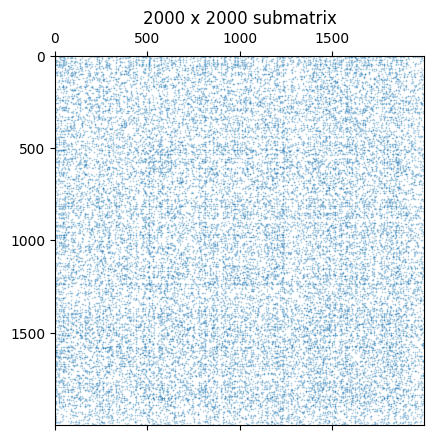

In [15]:
display(G)
spy(G[:2000, :2000], markersize=0.1)
title('2000 x 2000 submatrix');

In [16]:
start_timer();

Recall: $\mbox{(no. of triangles)} = \frac{1}{6} \sum_{a,c} \bigl[ G * (G \cdot G) \bigr]_{a,c}$

In [17]:
tri_count = int(G.multiply(G.dot(G)).sum()/6)

In [18]:
t_np = stop_timer(t_np)

In [19]:
print(f"==> Numpy-based method found {tri_count:,} triangles in {t_np:.3f} sec")

==> Numpy-based method found 24,620,528 triangles in 209.451 sec


## Summary ##

The three main tools of Module 2—SQL, pandas, and Numpy/Scipy—gave us different ways to solve the same problem:

- SQL gave us a _declarative_ method, where we say what we want, not how to get it;
- pandas is _imperative_, giving us more control over _how_ to do the calculation;
- and Numpy gave us _speed,_ in this special case where we could _transform_ the original problem into a linear algebraic form.

One is not always better than another, but a good way to build your intuition for which tool might yield a simpler or faster result is to practice solving problems using both SQL and pandas (or, when specialization admits, a Numpy-style method).

## Clean-up ##

In [20]:
imdb.close()